In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from matplotlib.colors import ListedColormap

In [ ]:
class MarketSimulator2D_CLA:
    def __init__(self, grid_size, symmetric = False, random_grid_probs = [1/3,1/3,1/3]):
        
        self.grid_size = grid_size

        self.BUY = 1
        self.HOLD = 0
        self.SELL = -1        
        self.neighbor_map = [(i, j) for i in [-1, 0, 1] for j in [-1, 0, 1] if not (i == 0 and j == 0)]
        self.random_grid_probs = random_grid_probs

        ### Grid Variables
        self.STATES = [self.BUY, self.HOLD, self.SELL]
        self.symmetric = symmetric
        self.grid = self.create_random_grid() if self.symmetric == False else self.create_symmetric_grid()

        # Reliability Weights Variables
        self.reliability_weights = np.ones((self.grid_size, self.grid_size, 8))

        self.grid_t_minus_1 = None

        # History Storage variables
        self.history = {"buy":[], "hold":[], "sell":[], "macro_factor":[]}        
        self.current_macro_info = "none"     
    
    def create_random_grid(self):
        """
        Creates and returns a grid with a random initial state, assuming uniform probabilities for all states, by default.
        Allows custom starting probabilities 
        """

        # Verify that the inputted probabilities list has length 3 and is a stochastic vector
        if isinstance(self.random_grid_probs, list):
            assert np.sum(self.random_grid_probs) == 1
            assert len(self.random_grid_probs) == 3

        return np.random.choice(self.STATES, size=(self.grid_size, self.grid_size), p = self.random_grid_probs)
    
    def create_symmetric_grid(self):
        """ 
        Creates a symmetric grid, analogous to the one presented in the reference paper
        """
        grid = np.full((self.grid_size, self.grid_size), self.SELL, dtype=int)

        buy_sell_length  = self.grid_size//3+1
        hold_length = self.grid_size-buy_sell_length

        start_hold = buy_sell_length//2
        end_hold = -(buy_sell_length//2+buy_sell_length%2)

        grid[start_hold:end_hold, start_hold:end_hold] = self.HOLD

        start_buy =  hold_length//2
        end_buy = -(hold_length//2+hold_length%2)

        grid[start_buy:end_buy, start_buy:end_buy] = self.BUY

        return grid
    
    def upload_external_grid(self, external_grid):
        """ 
        Simple function that supports inputting externally generated grids as starting grids
        """
        self.grid = external_grid
    
    def get_valid_neighbors_with_indices(self, i, j):

        neighbors = []
        for idx, (di, dj) in enumerate(self.neighbor_map):
            ni, nj = i + di, j + dj

            if 0 <= ni < self.grid_size and 0 <= nj < self.grid_size:
                neighbors.append({'coord': (ni, nj), 'weight_idx': idx})

        return neighbors
    
    def get_greatest_reliability_behavior(self, i, j):
        
        grid = self.grid

        neighbor_info = self.get_valid_neighbors_with_indices(i, j)        
        cell_weights = self.reliability_weights[i, j]

        buy_weight_sum = 0
        hold_weight_sum = 0
        sell_weight_sum = 0

        # Get the weights for each possible state
        for neighbor in neighbor_info:
            ni, nj = neighbor['coord']
            weight_idx = neighbor['weight_idx']
            
            neighbor_state = grid[ni, nj]
            weight = cell_weights[weight_idx]
            
            if neighbor_state == self.BUY:
                buy_weight_sum += weight
            elif neighbor_state == self.HOLD:
                hold_weight_sum += weight
            elif neighbor_state == self.SELL:
                sell_weight_sum += weight

        # Determine the most weighted state
        sums_array = np.array([buy_weight_sum, hold_weight_sum, sell_weight_sum])
        max_sum = np.max(sums_array)

        # Determine if there is a tie
        tie_count = np.sum(sums_array == max_sum)
        
        # NOT EXPLICITLY MENTIONED IN THE PAPER
        # As in Wei's paper implementation, we set up tie-breaking rules based on the macro-information
        if tie_count > 1:         
            macro_information = self.current_macro_info   
            if macro_information == "positive":
                return self.BUY
            if macro_information == "negative":
                return self.SELL
            else:
                return self.HOLD
        else:
            winner_index = np.argmax(sums_array)
            return self.STATES[winner_index]
        
    def calculate_all_rewards_penalties(self, theta, alpha):
        """
        Calculates the reward/penalty matrix based on the transition from grid_t_minus_1 to grid.
        This method implements the learning rules from Section 3.1 of the paper.
        """
        grid_t_minus_1 = self.grid_t_minus_1
        grid_t = self.grid

        rp_matrix = np.zeros_like(self.reliability_weights)

        # The learning process starts after the first step, so grid_t_minus_1 must exist.
        # If it doesn't exist, it won't change anything in the weights, and thus return a 0 reward-penalty matrix
        if grid_t_minus_1 is None:
            return rp_matrix

        # Calculate global counts for the previous (t-1) and current (t) steps
        prev_counts = {s: np.sum(grid_t_minus_1 == s) for s in self.STATES}
        current_counts = {s: np.sum(grid_t == s) for s in self.STATES}

        # Determine the majority behavior (T_max) for both steps
        t_max_prev = max(prev_counts, key=prev_counts.get)
        t_max_current = max(current_counts, key=current_counts.get)

        # --- Determine the Ct parameter (Formula 8) ---
        if t_max_current != t_max_prev:
            ct = 1.0
        else:
            prev_dominant_count = prev_counts[t_max_prev]
            current_dominant_count = current_counts[t_max_current]

            delta_t = current_dominant_count - prev_dominant_count
            ct = 1.0 + (delta_t / current_dominant_count)
        # ---------------------------------------------

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                # For each cell (i,j), evaluate the advice its neighbors gave in grid_t_minus_1

                neighbourhood = self.get_valid_neighbors_with_indices(i, j)
                num_neighbors = len(neighbourhood)
                
                # Count the states of neighbors in the previous and current step
                local_counts_t_minus_1 = {s: 0 for s in self.STATES}
                local_counts_t = local_counts_t_minus_1.copy()
                
                for neighbor in neighbourhood:
                    ni, nj = neighbor['coord']
                    local_counts_t_minus_1[grid_t_minus_1[ni, nj]] += 1
                    local_counts_t[grid_t[ni,nj]] += 1

                # N(x) - N_{x, T_max}(t-1)
                n_x_t_max = local_counts_t_minus_1[t_max_current]
                numerator = num_neighbors - n_x_t_max

                # Iterate through each neighbor to calculate its specific reward/penalty
                for neighbor in neighbourhood:
                    ni, nj = neighbor['coord']
                    weight_idx = neighbor['weight_idx']

                    neighbor_state_t = grid_t[ni, nj]
       
                    # --- Determine the Chi (χ) variable (Formula 6) ---
                    if neighbor_state_t == t_max_current:
                        chi = 1
                    # If neighbor was HOLD and HOLD was NOT the majority opinion
                    elif neighbor_state_t == self.HOLD and t_max_current != self.HOLD:
                        chi = -alpha
                    else:
                        chi = -(1 - alpha)
                    # -------------------------------------------------

                    # N(x) * N_{x, T_{x_i}}(t)
                    n_x_neighbor_state_t = local_counts_t[neighbor_state_t]
                    denominator = num_neighbors * n_x_neighbor_state_t

                    fraction = numerator / denominator
                    rp = chi * ct * theta * fraction
                    
                    rp_matrix[i, j, weight_idx] = rp

        return rp_matrix

    def get_transition_probabilities(self, majority_state, P, Mf, macro_info): 
            """Calculates transition probabilities based on Table 1 from the Wei et. al's paper."""
            probs = [0.0, 0.0, 0.0] # [prob_buy, prob_hold, prob_sell]

            if macro_info == "positive":
                if majority_state == self.BUY:
                    probs = [P + Mf, (1 - P - Mf) * 0.5, (1 - P - Mf) * 0.5]
                elif majority_state == self.HOLD:
                    probs = [(1 - P) * (0.5 + 0.5 * Mf), P, (1 - P) * (0.5 - 0.5 * Mf)]
                elif majority_state == self.SELL:
                    probs = [(1 - P) * (0.5 + 0.5 * Mf), (1 - P) * (0.5 - 0.5 * Mf), P]
            
            elif macro_info == "negative":
                if majority_state == self.BUY:
                    probs = [P, (1 - P) * (0.5 + 0.5 * Mf), (1 - P) * (0.5 - 0.5 * Mf)]
                elif majority_state == self.HOLD:
                    probs = [(1 - P) * (0.5 - 0.5 * Mf), P, (1 - P) * (0.5 + 0.5 * Mf)]
                elif majority_state == self.SELL:
                    probs = [(1 - P + Mf) * 0.5, (1 - P + Mf) * 0.5, P - Mf]

            elif macro_info == 'none':
                if majority_state == self.BUY:
                    probs = [P, (1 - P) * 0.5, (1 - P) * 0.5]
                elif majority_state == self.HOLD:
                    probs = [(1 - P) * 0.5, P, (1 - P) * 0.5]
                elif majority_state == self.SELL:
                    probs = [(1 - P) * 0.5, (1 - P) * 0.5, P]

            clipped_probs = np.clip(probs, 0, 1)

            prob_sum = np.sum(clipped_probs)

            # if the sum of the probabilities is 0, return uniform probabilities for all states
            if prob_sum == 0:
                return [1/3, 1/3, 1/3]

            # renormalize the probabilities to ensure that they sum to one
            normalized_probs = clipped_probs / prob_sum

            # store the an array containing the transition probabilities for the 3 states, in order: BUY, HOLD, SELL
            return [normalized_probs[0], normalized_probs[1], normalized_probs[2]]

    def update_grid(self, P):

        # generate the new grid which represents the state at the enxt step
        new_grid = np.zeros_like(self.grid)

        macro_factor = self.history["macro_factor"][-1]
        macro_info = self.current_macro_info

        # for each cell in the grid, determine the behaviour with greates reliability, and then determine the transition probabilities for that cell
        # At last determine the state of that cell in the next step
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                greatest_reliability_behaviour = self.get_greatest_reliability_behavior(i, j)                            
                probs = self.get_transition_probabilities(greatest_reliability_behaviour,
                                                        P,
                                                        macro_factor, 
                                                        macro_info)    
                        
                new_grid[i, j] = np.random.choice(self.STATES, p=probs)
        
        # update grid_t_minus_1 and current grid class properties
        self.grid_t_minus_1 = self.grid.copy()
        self.grid = new_grid

    def update_history(self):
        self.history["buy"].append(np.sum(self.grid == self.BUY))
        self.history["hold"].append(np.sum(self.grid == self.HOLD))
        self.history["sell"].append(np.sum(self.grid == self.SELL)) 

    def update_reliability_weights(self,theta, alpha):
        rp_matrix = self.calculate_all_rewards_penalties(theta, alpha)
        self.reliability_weights += rp_matrix   

    def update_macro_factor(self, macro_factor_volatility, clip = False):
        random_step = np.random.normal(loc=0.0, scale=macro_factor_volatility)

        # update the macro-factor, which behaves like a random walk
        macro_factor_current = self.history["macro_factor"][-1] + random_step

        if clip == True:
            # possibility to clip the macro-factor, if needed
            macro_factor_current = np.clip(macro_factor_current, -1, 1)

        # update the macro-factor in the history dictionary
        self.history["macro_factor"].append(macro_factor_current)        

        # update the macroeconomic information
        macro_info_current = "positive" if macro_factor_current > 0 else "negative" if macro_factor_current < 0 else "none"
        self.current_macro_info = macro_info_current

    def run_simulation(self, num_steps, P, alpha, theta, initial_mf=0.0, mf_volatility=0.05, clip_macro_factor = False, updated_grid = False):
        
        # Initialize the grid from scratch
        if self.symmetric == False and updated_grid == False:
             self.grid = self.create_random_grid() 
        elif self.symmetric == False:
            self.symmetric = updated_grid
        elif self.symmetric == True:
            self.grid == self.create_symmetric_grid()

        # Initialize from zero the history dictionary
        self.history = {"buy": [], "hold": [], "sell": [], "macro_factor": []}
        self.reliability_weights.fill(1.0) # Reset weights to 1 for each run
        
        mf_current = initial_mf        
        self.history["macro_factor"].append(mf_current)
        
        # update buy, hold, sell values based on the results of the starting grid
        self.update_history()

        for step in range(num_steps):
            self.update_reliability_weights(theta, alpha)
            self.update_macro_factor(mf_volatility, clip = clip_macro_factor)   
            self.update_grid(P)
            self.update_history()
    
    def plot_grid(self, title=None, ax = None):
        ax = ax
        
        if ax == None:
            fig, ax = plt.subplots(1,1,figsize = (10,10))
        
        cmap = ListedColormap(['red', 'lightgray', 'green'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        ax.imshow(self.grid, cmap=cmap, norm=norm)
        ax.set_title(title if title else "Current Grid State")
        ax.set_xticks([])
        ax.set_yticks([])

    def plot_hist(self, title=None, ax = None, only_holders = False, holders_color = "grey"):

        ax = ax

        if ax == None:
            fig, ax = plt.subplots(1,1,figsize = (10,10))         
        
        if only_holders == False:
            ax.plot(self.history["buy"], label="Buy", color='green')
            ax.plot(self.history["sell"], label="Sell", color=  'red')  
        
        ax.plot(self.history["hold"], label="Hold", color = holders_color)

        ax.set_xlabel('time step')

        if only_holders == False:
            ax.set_ylabel('number of each behaviour')
        else:
            ax.set_ylabel("number of holders")
        ax.grid(True)
        ax.set_title(title if title else "Investment Behavior Over Time")
        ax.legend()


In [4]:
model = MarketSimulator2D_CLA(50, True)

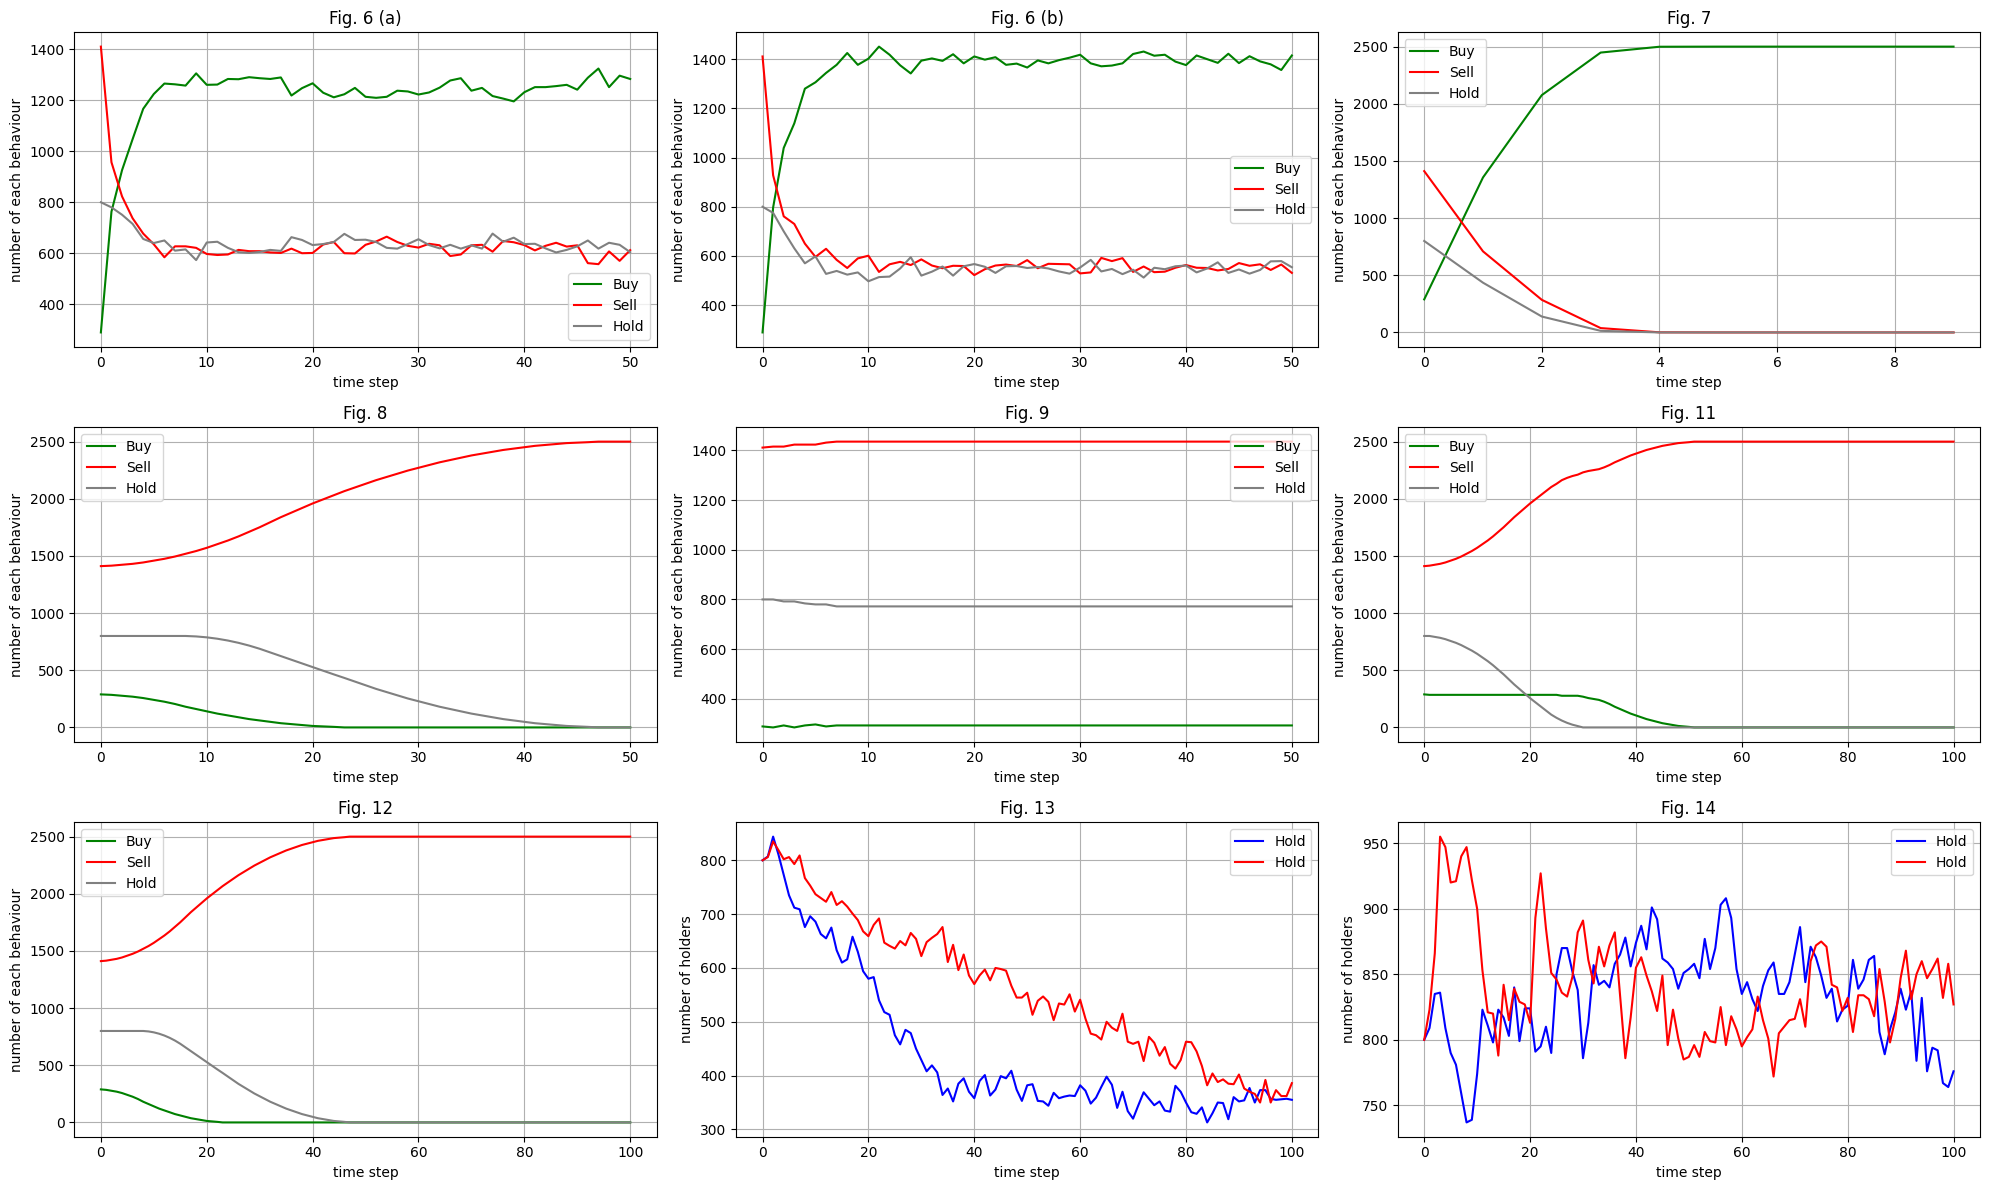

In [35]:
fig, axs = plt.subplots(3,3,figsize = (20,12))

# Figure 6 A
model.run_simulation(num_steps=50,
                    P =0.5,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_hist(ax = axs[0,0], title= "Fig. 6 (a)")

# Figure 6 B
model.run_simulation(num_steps=50,
                    P =0.5,
                    alpha= 0,
                    theta= 0,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_hist(ax = axs[0,1], title = "Fig. 6 (b)")

# Figure 7
model.run_simulation(num_steps=9,
                    P =0.5,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.9,
                    mf_volatility= 0)

model.plot_hist(ax = axs[0,2], title = "Fig. 7")

# Figure 8

model.run_simulation(num_steps=50,
                    P =1,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.9,
                    mf_volatility= 0)

model.plot_hist(ax = axs[1,0], title = "Fig. 8")

# Figure 9

model.run_simulation(num_steps=50,
                    P =1,
                    alpha= 0,
                    theta= 0,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_hist(ax = axs[1,1], title = "Fig. 9")

# Figure 11

model.run_simulation(num_steps=100,
                    P =1,
                    alpha= 0.5,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(ax = axs[1,2], title = "Fig. 11")


# Figure 12
model.run_simulation(num_steps=100,
                    P =1,
                    alpha= 0.2,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(ax = axs[2,0], title = "Fig. 12")

# Figure 13

model.run_simulation(num_steps=100,
                    P =0.75,
                    alpha= 0.5,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(only_holders= True, holders_color= "blue", ax =axs[2,1], title = "Fig. 13")

model.run_simulation(num_steps=100,
                    P =0.75,
                    alpha= 0.2,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(only_holders= True, holders_color= "red", ax = axs[2,1], title = "Fig. 13")

# Figure 14

model.run_simulation(num_steps=100,
                    P =0.5,
                    alpha= 0.5,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(only_holders= True, ax = axs[2,2], holders_color= "blue", title = "Fig. 14")

model.run_simulation(num_steps=100,
                    P =0.5,
                    alpha= 0.2,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(only_holders= True, ax = axs[2,2], holders_color= "red", title = "Fig. 14")

plt.tight_layout()


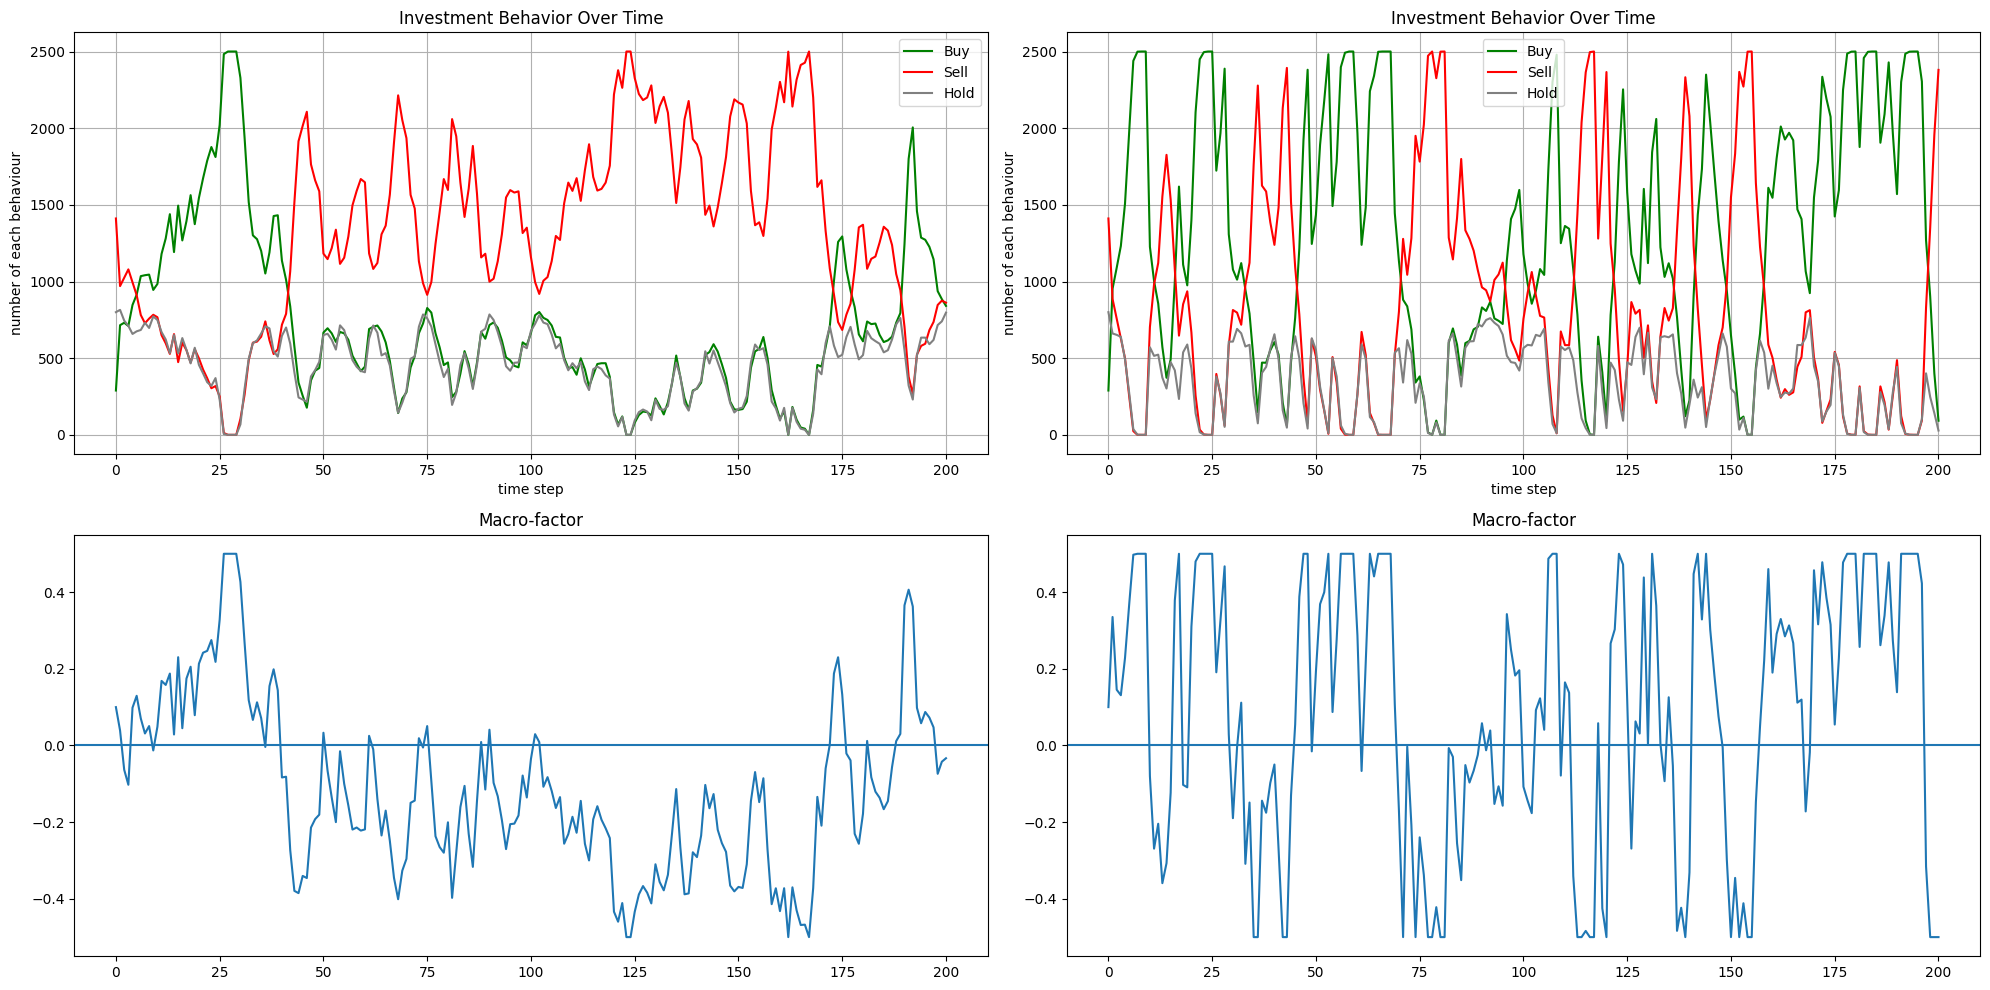

In [10]:
fig, axs = plt.subplots(2,2,figsize = (20,10))

# Figure 18

model.run_simulation(num_steps=200,
                    P =0.5,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.1,
                    mf_volatility= 0.1,
                    clip_macro_factor= True)


model.plot_hist(ax = axs[0,0])

axs[1,0].set_title("Macro-factor")
axs[1,0].plot(model.history["macro_factor"]);
axs[1,0].axhline(0)

# Figure 19

model.run_simulation(num_steps=200,
                    P =0.5,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.1,
                    mf_volatility= 0.3,
                    clip_macro_factor= True)


model.plot_hist(ax = axs[0,1])

axs[1,1].set_title("Macro-factor")
axs[1,1].plot(model.history["macro_factor"]);
axs[1,1].axhline(0)

plt.tight_layout()


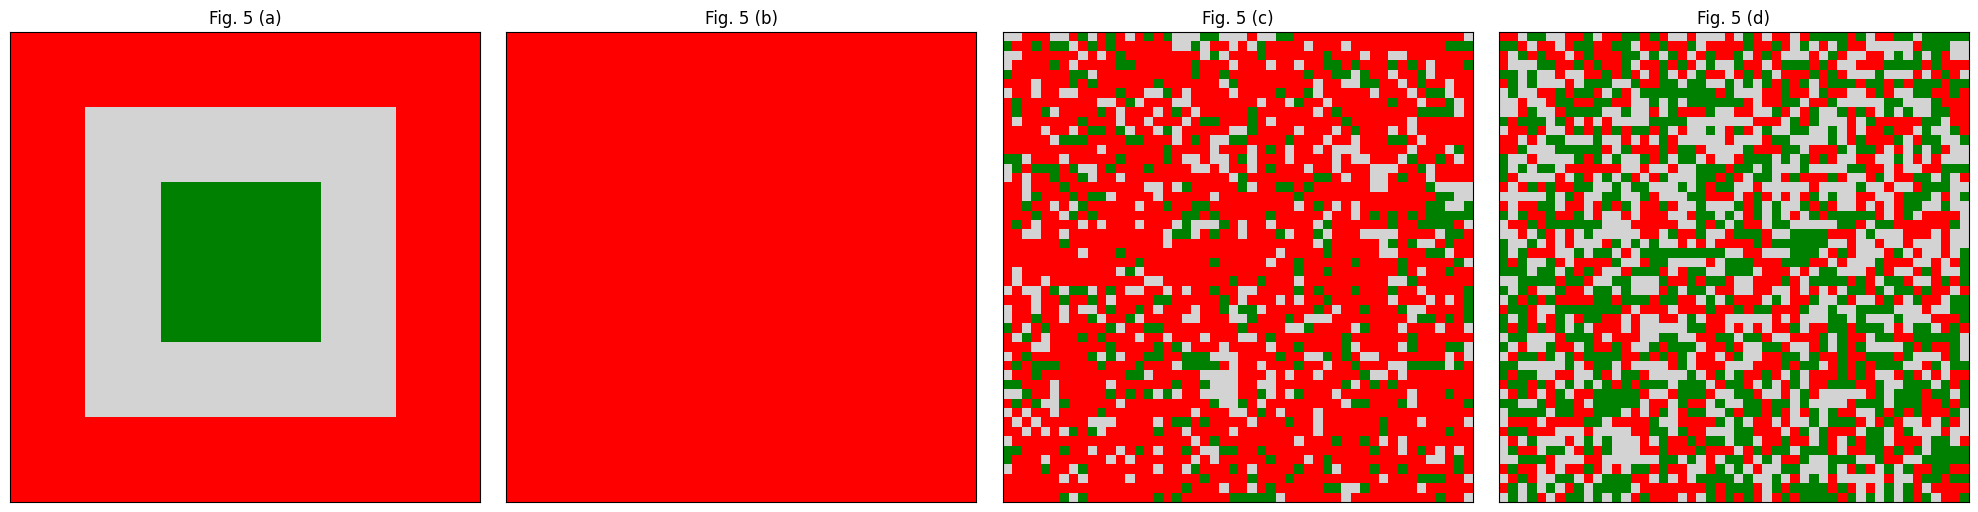

In [37]:
# Figure 5

fig, ax = plt.subplots(1,4,figsize = (20,5))

model.grid = model.create_symmetric_grid()
model.plot_grid(ax = ax[0], title = "Fig. 5 (a)")


model.run_simulation(num_steps=330,
                    P =1,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_grid(ax = ax[1], title = "Fig. 5 (b)")

model.run_simulation(num_steps=370,
                    P =0.75,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_grid(ax = ax[2], title = "Fig. 5 (c)")

model.run_simulation(num_steps=370,
                    P =0.50,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_grid(ax = ax[3], title = "Fig. 5 (d)")

plt.tight_layout()



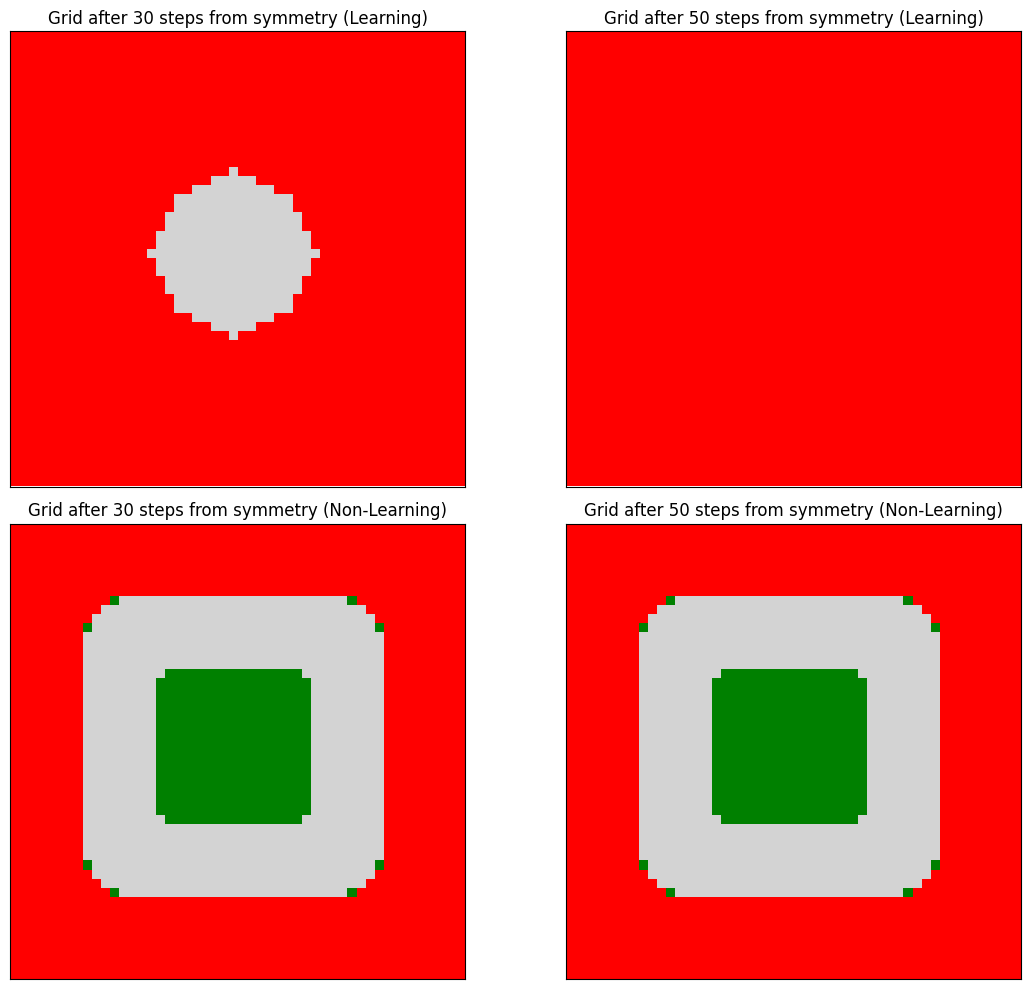

In [38]:
fig, axs = plt.subplots(2,2,figsize = (12,10))

# Figure 10

model.run_simulation(num_steps=30,
                    P =1,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_grid(ax = axs[0,0], title = "Grid after 30 steps from symmetry (Learning)")


model.run_simulation(num_steps=50,
                    P =1,
                    alpha= 0.25,
                    theta= 0.02,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_grid(ax = axs[0,1], title = "Grid after 50 steps from symmetry (Learning)")

# Figure 10 (b) (Non-Learning Model)

model.run_simulation(num_steps=30,
                    P =1,
                    alpha= 0.25,
                    theta= 0,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_grid(ax = axs[1,0], title = "Grid after 30 steps from symmetry (Non-Learning)")


model.run_simulation(num_steps=50,
                    P =1,
                    alpha= 0.25,
                    theta= 0,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_grid(ax = axs[1,1], title = "Grid after 50 steps from symmetry (Non-Learning)")

plt.tight_layout()



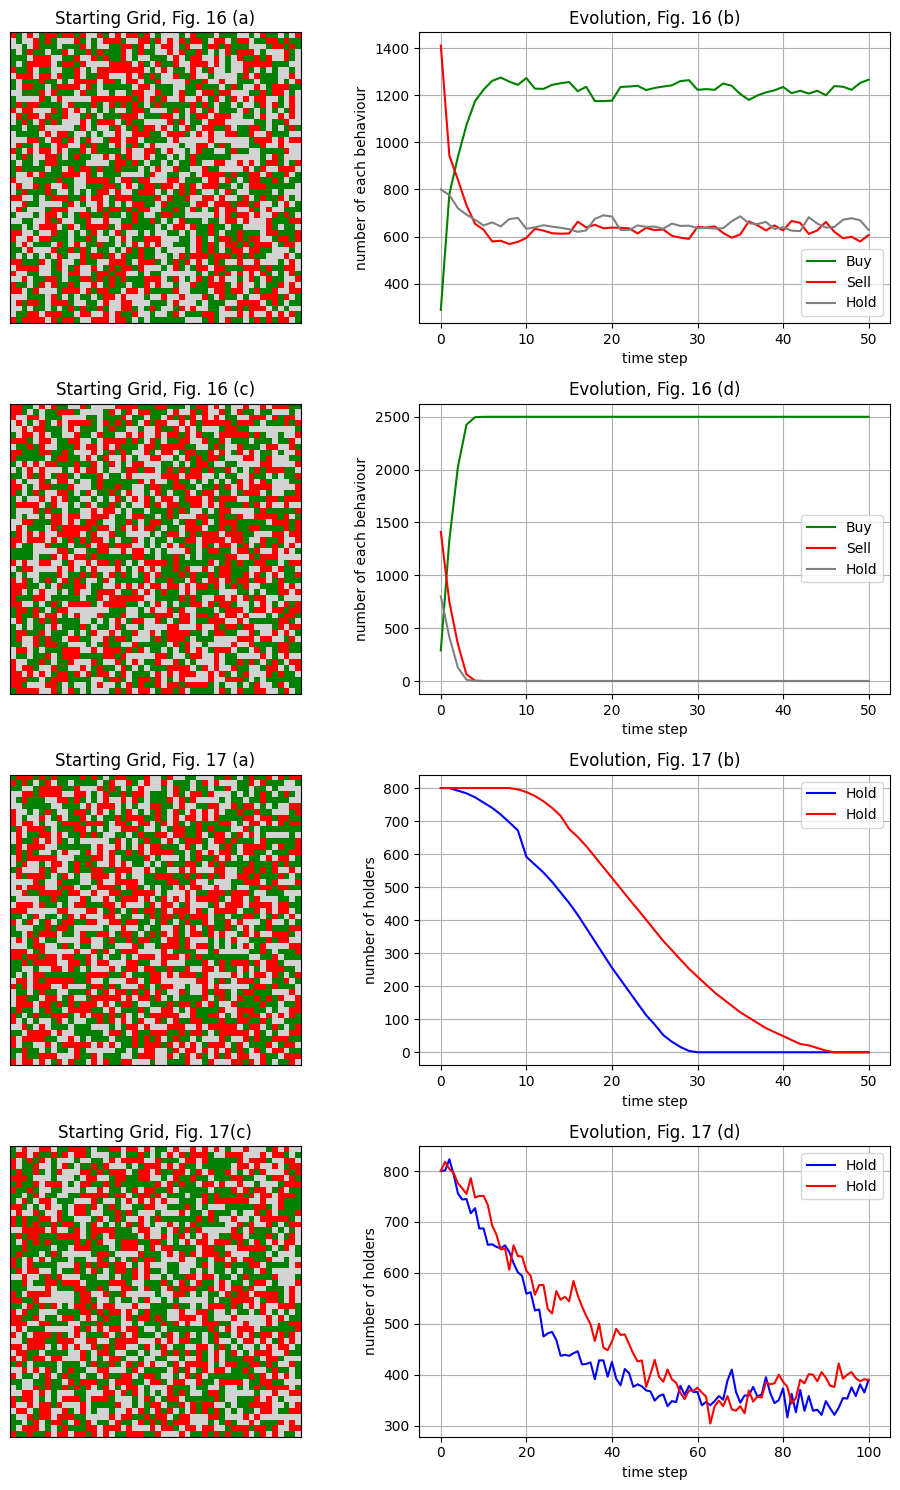

In [41]:
fig, axs = plt.subplots(4,2,figsize = (10,15))

# Figure 16 (a)

model.grid = model.create_random_grid()
model.plot_grid(ax = axs[0,0], title = "Starting Grid, Fig. 16 (a)")

model.run_simulation(num_steps=50,
                    P =0.5,
                    alpha= 0.2,
                    theta= 0.02,
                    initial_mf= 0.1,
                    mf_volatility= 0)

model.plot_hist(ax = axs[0,1], title = "Evolution, Fig. 16 (b)")

# Figure 16 (b)

model.grid = model.create_random_grid()
model.plot_grid(ax = axs[1,0], title = "Starting Grid, Fig. 16 (c)")

model.run_simulation(num_steps=50,
                    P =0.5,
                    alpha= 0.2,
                    theta= 0.02,
                    initial_mf= 0.9,
                    mf_volatility= 0)

model.plot_hist(ax = axs[1,1], title = "Evolution, Fig. 16 (d)")

# Figure 17 (a)


model.grid = model.create_random_grid()
grid = model.grid.copy()

model.plot_grid("Starting Grid, Fig. 17 (a)", ax = axs[2,0])

model.run_simulation(num_steps=50,
                    P =1,
                    alpha= 0.5,
                    theta= 0.2,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(holders_color= "blue", only_holders= True, ax = axs[2,1], title = "Evolution, Fig. 17 (b)")

model.grid = grid

model.run_simulation(num_steps=50,
                    P =1,
                    alpha= 0.2,
                    theta= 0.2,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(holders_color= "red", only_holders= True, ax = axs[2,1], title = "Evolution, Fig. 17 (b)")

# Figure 17 (b)

model.grid = model.create_random_grid()
grid = model.grid.copy()

model.plot_grid(ax = axs[3,0], title = "Starting Grid, Fig. 17(c)")

model.run_simulation(num_steps=100,
                    P =0.75,
                    alpha= 0.5,
                    theta= 0.2,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(holders_color= "blue", only_holders= True, ax = axs[3,1], title = "Starting Grid, Fig. 17 (d)")

model.grid = grid

model.run_simulation(num_steps=100,
                    P =0.75,
                    alpha= 0.2,
                    theta= 0.2,
                    initial_mf= 0,
                    mf_volatility= 0)

model.plot_hist(holders_color= "red", only_holders= True, ax = axs[3,1], title = "Evolution, Fig. 17 (d)")

plt.tight_layout()

